In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [213]:
#Fit principa axis via SVD
def fitsvd (xpoints, ypoints, zpoints):
    x = np.array(xpoints)
    y = np.array(ypoints)
    z = np.array(zpoints)

    data = np.concatenate((x[:, np.newaxis], 
                           y[:, np.newaxis], 
                           z[:, np.newaxis]), 
                          axis=1)

    # Calculate the mean of the points, i.e. the 'center' of the cloud
    datamean = data.mean(axis=0)

    # Do an SVD on the mean-centered data.
    uu, dd, vv = np.linalg.svd(data - datamean)

    # Now vv[0] contains the first principal component, i.e. the direction
    # vector of the 'best fit' line in the least squares sense.

    # dd[0] contains the singlar value corresponding to vv[0], so the RMS
    # _along_ that principal component - i.e. the RMS length

    dir = np.array([vv[0][0],vv[0][1],vv[0][2]])
    return dir, dd, datamean

In [23]:
# Plot a charge distribution as well as the initial direction (label)
def plot_track_dir(x_points, y_points, z_points, start, direction):

    # Plot the track
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter3D(x_points, y_points, z_points, c='k', marker='o')

    ax.set_xlabel('x [cm]')
    ax.set_ylabel('y [cm]')
    ax.set_zlabel('z [cm]')
    plt.tight_layout()

    # Add red line for true direction (z direction)
    #ax.plot3D([vector_tail[0],vector_head[0]], [vector_tail[1],vector_head[1]], [vector_tail[2],vector_head[2]], c='r')
    ax.quiver(start[0],start[1],start[2],direction[0],direction[1],direction[2], linewidths=3, color = 'red')

    plt.show()


In [24]:
# Specify location of data file
data_loc = '/Users/majdghrear/data/e_dir_fit'

# The data is stored in 100 pickle files each containing 10k electron recoil simulations
files_e = [data_loc+'/processed_training_data/processed_recoils_'+str(i)+'.pk' for i in range(1) ]

In [25]:
df = pd.read_pickle(files_e[0])

In [31]:
df.head()

,x,y,z,dir,offset,diff
0,"[-0.05857784268729732, -0.1371165810167607, -0...","[0.23619832792992274, 0.43236885897004895, 0.4...","[0.22464089843090784, -2.415906797373107, -2.3...","[-0.4198009988390553, -0.4440823098716106, 0.7...","[-0.13160994280565688, 0.44427934344609393, -2...",0.020573
1,"[1.6931095431139895, -3.716856911553106, -3.72...","[-0.016570522623699763, -0.1696650057302022, -...","[0.06388297560470213, 0.5521963269308606, 0.53...","[0.8091878989484278, 0.2779066779977132, -0.51...","[-3.8146877165052913, -0.16486621019948325, 0....",0.026837
2,"[0.7855689290923329, -2.817765238526957, -2.79...","[-0.2800626173192523, -0.21091611350152167, -0...","[0.8258045018642259, -2.157426671373328, -2.12...","[0.9292584753858835, 0.36787504773435054, -0.0...","[-2.8848038745477615, -0.18587373584726274, -2...",0.032068
3,"[1.015111345763847, -2.660967094139635, -2.654...","[-0.39574664837196294, 0.413432985633008, 0.35...","[-0.44343663674671585, 0.6854876509710981, 0.6...","[0.6975108938815566, -0.6644836831430804, 0.26...","[-2.640509097021054, 0.40556093511292457, 0.66...",0.043303
4,"[-1.8545992117462908, 1.5576949443730022, 1.53...","[0.3849699928974448, -1.4759979806067143, -1.4...","[0.27955840384524056, -2.3168030993740714, -2....","[0.32184656062767913, 0.5144094887414011, 0.79...","[1.5512170253679882, -1.523265044801098, -2.37...",0.025124


In [202]:
track = df.iloc[18]

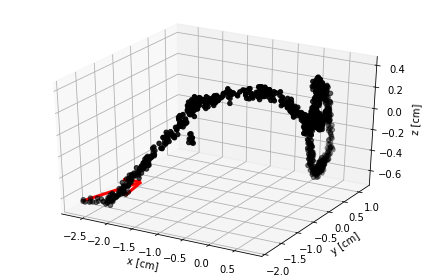

In [203]:
# Plot the track

plot_track_dir(track['x'], track['y'], track['z'], track['offset'], track['dir'])

In [221]:
# this treatment does not includes weights (charge)

# Specify parameters of algorithim 
N_pt = 100
w_p = 2

#Find barycenter
Bc = np.array([np.mean(track.x),np.mean(track.y),np.mean(track.z)])



In [222]:
# radius [cm]
r_opt = 0
for r in np.arange(0,5,0.0001):

    N = np.sum( ( (track.x-Bc[0])**2 + (track.y-Bc[1])**2 + (track.z-Bc[2])**2 ) > r**2)

    if N == N_pt:
        r_opt = r
        break

filter = ( (track.x-Bc[0])**2 + (track.y-Bc[1])**2 + (track.z-Bc[2])**2 ) > r_opt**2

r_opt




2.2706

In [223]:
x_IP = track.x[filter]
y_IP = track.y[filter]
z_IP = track.z[filter]

# Weights, will need to multiply this by charge in the end
W = np.exp(-1.0 * np.sqrt(x_IP**2+y_IP**2+z_IP**2) / w_p)



# Need to include weight treatement here
dir, dd, datamean =fitsvd(x_IP,y_IP,z_IP)

In [226]:
x = np.array(x_IP)
y = np.array(y_IP)
z = np.array(z_IP)

data = np.concatenate((x[:, np.newaxis], 
                        y[:, np.newaxis], 
                        z[:, np.newaxis]), 
                        axis=1)

# Calculate the mean of the points, i.e. the 'center' of the cloud
datamean = data.mean(axis=0)

uu, dd, vv = np.linalg.svd(data - datamean)

In [230]:
data - datamean

array([[-5.90097993e-01, -1.91888154e-01, -1.15607347e-01],
       [-5.21458617e-01, -2.36868346e-01, -1.22169718e-01],
       [-6.01518918e-01, -1.86624737e-01, -1.33111038e-01],
       [-4.91358162e-01, -1.28556365e-01, -1.01803333e-01],
       [-4.12139885e-01, -1.71789983e-01, -1.22349589e-01],
       [-4.87773183e-01, -1.61210737e-01, -1.35123447e-01],
       [-3.88815561e-01, -1.10328564e-01, -1.36819635e-01],
       [-3.61448925e-01, -1.05437213e-01, -9.46436788e-02],
       [-3.60097562e-01, -8.87566964e-02, -1.26775955e-01],
       [-2.85769287e-01, -1.03906012e-01, -9.49581406e-02],
       [-2.75317675e-01, -6.40898751e-02, -1.24422695e-01],
       [-2.87702711e-01, -5.14238268e-02, -1.34533645e-01],
       [-2.05761400e-01, -5.39626888e-02, -1.12075145e-01],
       [-2.04953962e-01, -2.02917340e-02, -1.20792492e-01],
       [-1.42614241e-01, -3.75777245e-02, -1.10750408e-01],
       [-1.81189676e-01, -7.99160352e-03, -1.11386885e-01],
       [-1.93010360e-01, -4.25643659e-02

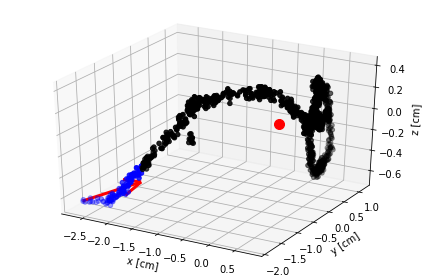

In [212]:
# Plot the track
fig = plt.figure()
ax = plt.axes(projection='3d')



# Plot points not in IP
ax.scatter3D(track.x[~filter], track.y[~filter], track.z[~filter], c='k', marker='o')

# Plot points in IP
ax.scatter3D(x_IP, y_IP, z_IP, c='b', marker='o')

# Plot baryceneter
ax.scatter3D(Bc[0], Bc[1], Bc[2], c='r', marker='o', s=100)

ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
ax.set_zlabel('z [cm]')
plt.tight_layout()

# Add red line for true direction (z direction)
#ax.plot3D([vector_tail[0],vector_head[0]], [vector_tail[1],vector_head[1]], [vector_tail[2],vector_head[2]], c='r')
ax.quiver(track['offset'][0],track['offset'][1],track['offset'][2],track['dir'][0],track['dir'][1],track['dir'][2], linewidths=3, color = 'red')